# Gaussian covariance matrix estimation

Suppose $y_i \in \mathbb{R}^n$ for $i = 1, \ldots, N$ are points drawn i.i.d.from 
$\mathcal{N}(0,\Sigma)$. Our goal is to estimate the parameter $\Sigma$ given these 
samples.

The maximum likelihood problem of estimating $\Sigma$ is convex in the inverse of 
$\Sigma$, but not $\Sigma$.  

If there are no other constraints on $\Sigma$, the maximum likelihood estimate is 

$$
\hat{\Sigma} = \frac{1}{N} \sum_{i=1}^N y_i y_i^T,
$$

the empirical covariance matrix.  

In [3]:
"""DCCP package."""

import matplotlib.pyplot as plt
import numpy as np
import cvxpy as cp
from dccp import is_dccp

rng = np.random.default_rng(0)
n = 20
N = 30
mean = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
cov = np.eye(n)

for i in range(0, n - 3):
    cov[i, i + 3] = -0.2
    cov[i + 3, i] = -0.2
for i in range(0, n - 6):
    cov[i, i + 6] = 0.6
    cov[i + 6, i] = 0.6
pos = cov > 0
neg = cov < 0
zero = cov == 0

y = np.zeros((n, N))
Sigma = cp.Variable((n, n))

t = cp.Variable(1)
cost = cp.log_det(Sigma) + t
t.value = [1]
Sigma.value = np.eye(n)

emp = np.zeros((n, n))
for k in range(N):
    y[:, k] = rng.multivariate_normal(mean, cov)
    emp = emp + np.outer(y[:, k], y[:, k]) / N
temp = cp.sum([cp.matrix_frac(y[:, i], Sigma) / N for i in range(N)])
trace_val = temp
constr = [
    trace_val <= t,
    cp.multiply(pos, Sigma) >= 0,
    cp.multiply(neg, Sigma) <= 0,
    cp.multiply(zero, Sigma) == 0,
]
prob = cp.Problem(cp.Minimize(cost), constr)
assert is_dccp(prob)
result = prob.solve(method="dccp", max_iter=10, solver="SCS", 
    max_slack=1e-3, eps=1e-3, seed=0
)
assert result is not None
assert Sigma.value is not None

## Numerical example

We consider here the case where the sign of the off-diagonal entries in $\Sigma$ is 
known; that is, we know which entries of $\Sigma$ are negative, which are zero, and 
which are positive. (So we know which components of $y$ are uncorrelated, and which are 
negatively and positively correlated.)  

The maximum likelihood problem is then

$$
\begin{array}{ll}
\text{maximize} & -\log \det(\Sigma) - \frac{1}{N} \sum_{i=1}^N y_i^T \Sigma^{-1} y_i \\
\text{subject to} & \Sigma_{\Omega_+} \geq 0, \quad 
                    \Sigma_{\Omega_-} \leq 0, \quad 
                    \Sigma_{\Omega_0} = 0,
\end{array}
$$

where $\Sigma$ is the variable, and the index sets $\Omega_+$, $\Omega_-$, and 
$\Omega_0$ are given. The objective is a difference of convex functions, so we transform 
the problem into the following DCCP problem with additional variable $t$,

$$
\begin{array}{ll}
\text{maximize} & -\log \det(\Sigma) - t \\
\text{subject to} & \frac{1}{N} \sum_{i=1}^N y_i^T \Sigma^{-1} y_i \leq t, \\
& \Sigma_{\Omega_+} \geq 0, \quad 
  \Sigma_{\Omega_-} \leq 0, \quad 
  \Sigma_{\Omega_0} = 0.
\end{array}
$$


An example with $n=20$ and $N=30$ is shown below.

Not surprisingly, knowledge of the signs of the entries of $\Sigma$ allows us to obtain 
a much better estimate of the true covariance matrix.

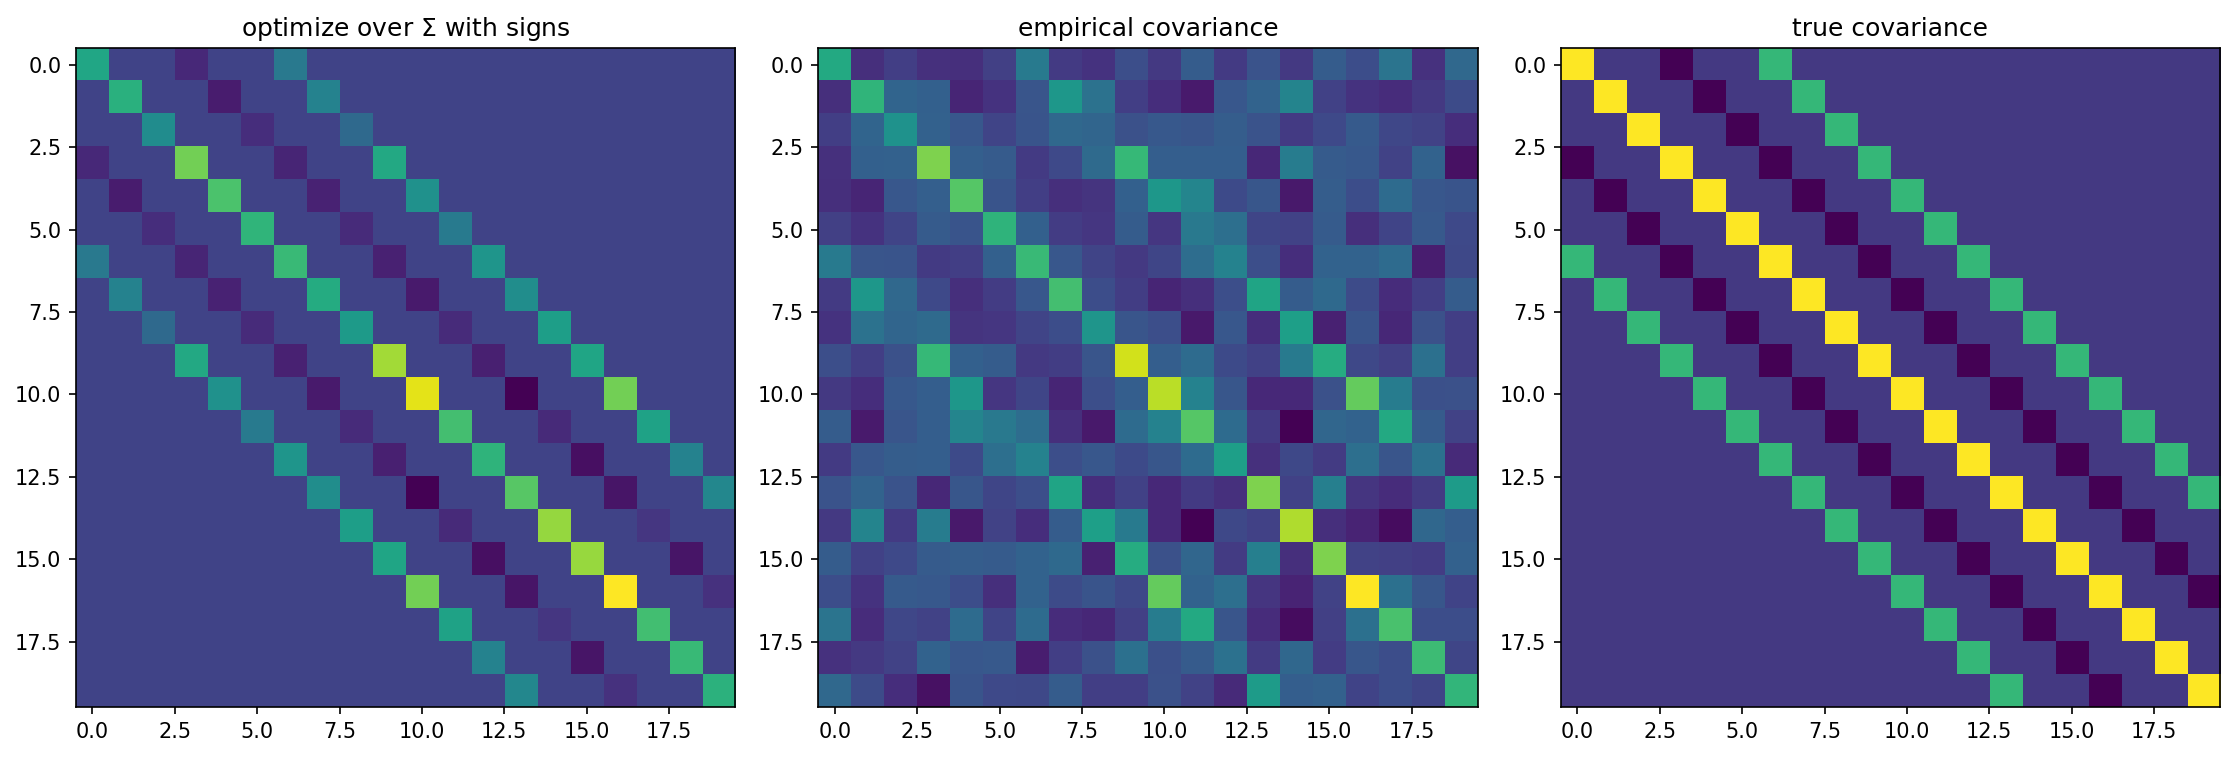

In [4]:
plt.figure(figsize=(15, 5), dpi=150)
plt.subplot(131)
plt.imshow(Sigma.value, interpolation="none")
plt.title("optimize over $\Sigma$ with signs")
plt.subplot(132)
plt.imshow(emp, interpolation="none")
plt.title("empirical covariance")
plt.subplot(133)
plt.imshow(cov, interpolation="none")
plt.title("true covariance")
plt.tight_layout()